In [1]:

import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images

In [2]:
path="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir=path+"/train"
valid_dir=path+"/valid"

In [3]:
disease=os.listdir(train_dir)

In [4]:
len(disease)

38

In [5]:
plants=[]
for i in disease:
    k=i.split("__")
    if k[0] not in plants:
        plants.append(k[0])
plants

['Tomato',
 'Grape',
 'Orange',
 'Soybean',
 'Squash',
 'Potato',
 'Corn_(maize)',
 'Strawberry',
 'Peach',
 'Apple',
 'Blueberry',
 'Cherry_(including_sour)',
 'Pepper,_bell',
 'Raspberry']

In [6]:
lis=[]
no=0
for i in disease:
    pat=len(os.listdir(train_dir+"/"+str(i)))
    lis.append((i,pat))
    no+=pat
lis


[('Tomato___Late_blight', 1851),
 ('Tomato___healthy', 1926),
 ('Grape___healthy', 1692),
 ('Orange___Haunglongbing_(Citrus_greening)', 2010),
 ('Soybean___healthy', 2022),
 ('Squash___Powdery_mildew', 1736),
 ('Potato___healthy', 1824),
 ('Corn_(maize)___Northern_Leaf_Blight', 1908),
 ('Tomato___Early_blight', 1920),
 ('Tomato___Septoria_leaf_spot', 1745),
 ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 1642),
 ('Strawberry___Leaf_scorch', 1774),
 ('Peach___healthy', 1728),
 ('Apple___Apple_scab', 2016),
 ('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 1961),
 ('Tomato___Bacterial_spot', 1702),
 ('Apple___Black_rot', 1987),
 ('Blueberry___healthy', 1816),
 ('Cherry_(including_sour)___Powdery_mildew', 1683),
 ('Peach___Bacterial_spot', 1838),
 ('Apple___Cedar_apple_rust', 1760),
 ('Tomato___Target_Spot', 1827),
 ('Pepper,_bell___healthy', 1988),
 ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 1722),
 ('Potato___Late_blight', 1939),
 ('Tomato___Tomato_mosaic_virus', 1790),
 ('Strawbe

In [7]:
print(no)
print(len(lis))

70295
38


In [8]:
ns=0
for i in disease:
    pat=len(os.listdir(valid_dir+"/"+str(i)))
    ns+=pat
print(ns)

17572


In [9]:
data=pd.DataFrame(data=lis,columns=['disease','no of images'])

In [10]:
data

,disease,no of images
0,Tomato___Late_blight,1851
1,Tomato___healthy,1926
2,Grape___healthy,1692
3,Orange___Haunglongbing_(Citrus_greening),2010
4,Soybean___healthy,2022
5,Squash___Powdery_mildew,1736
6,Potato___healthy,1824
7,Corn_(maize)___Northern_Leaf_Blight,1908
8,Tomato___Early_blight,1920
9,Tomato___Septoria_leaf_spot,1745


In [11]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train=ImageFolder(train_dir,transform=transforms.ToTensor())
valid=ImageFolder(valid_dir,transform=transforms.ToTensor())

In [14]:
random_seed=7
torch.manual_seed(random_seed)

In [15]:
#Data loaders for training and validation
train_dl=DataLoader(train,batch_size=32,shuffle=True,pin_memory=True)
valid_dl=DataLoader(valid,batch_size=32,shuffle=True,pin_memory=True)

In [16]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [17]:
#Convoliton Block
def ConvBlock(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channels),
           nn.ReLU()]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

In [18]:
# Architecture of Resnet9
class Resnet9(nn.Module):
    def __init__(self,input_channels,output_classes):
        super().__init__()
        #input_dimension=[32,3,256,256]
        #stage-1
        self.conv1=ConvBlock(input_channels,64)#output_dimension=[32,64,256,256]
        self.conv2=ConvBlock(64,128,pool=True)#output_dimension=[32,128,64,64]
        self.res1=nn.Sequential(ConvBlock(128,128),ConvBlock(128,128))
        
        #stage-2
        self.conv3=ConvBlock(128,256,pool=True)#output_dimension=[32,256,16,16]
        self.conv4=ConvBlock(256,512,pool=True)#output_dimension=[32,512,4,4]
        self.res2=nn.Sequential(ConvBlock(512,512),ConvBlock(512,512))
        
        #stage-3
        self.classifier=nn.Sequential(nn.MaxPool2d(4),nn.Flatten(),nn.Linear(512,38))
        
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.conv2(output)
        output=self.res1(output)+output
        output=self.conv3(output)
        output=self.conv4(output)
        output=self.res2(output)+output
        output=self.classifier(output)
        return output

In [19]:
model = to_device(Resnet9(3, len(disease)), device) 
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv3): Sequential(
    (0): Co

In [20]:
from torch.optim import Adam
#Optimizer and Loss Function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [21]:
from torch.autograd import Variable
#model_training and Saving the best Model
best_accuracy=0.0
train_accuracy=0.0
train_loss=0.0
test_accuracy=0.0
for epoch in range(13):
    best_accuracy=0.0
    train_accuracy=0.0
    train_loss=0.0
    #training and Evaluation
    for i,(images,labels) in enumerate(train_dl):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=train_accuracy/no
    train_loss=train_loss/no   
    #for eavaluating the model
    model.eval()
    for i,(images,labels) in enumerate(valid_dl):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
        optimizer.zero_grad()  
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    test_accuracy=test_accuracy/ns
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

Epoch: 0 Train Loss: tensor(0.5301) Train Accuracy: 0.8442278967209617 Test Accuracy: 0.8868654677896654
Epoch: 1 Train Loss: tensor(0.1481) Train Accuracy: 0.9521445337506224 Test Accuracy: 0.9597021890204752
Epoch: 2 Train Loss: tensor(0.1067) Train Accuracy: 0.9650899779500676 Test Accuracy: 0.9708604428744038
Epoch: 3 Train Loss: tensor(0.0763) Train Accuracy: 0.9756881712781847 Test Accuracy: 0.9772917630572999
Epoch: 4 Train Loss: tensor(0.0644) Train Accuracy: 0.9788320648694786 Test Accuracy: 0.9796253865105314
Epoch: 5 Train Loss: tensor(0.0515) Train Accuracy: 0.9832278255921474 Test Accuracy: 0.9838367644768102
Epoch: 6 Train Loss: tensor(0.0517) Train Accuracy: 0.9826303435521729 Test Accuracy: 0.9854304482565717
Epoch: 7 Train Loss: tensor(0.0425) Train Accuracy: 0.986286364606302 Test Accuracy: 0.9854305389510731
Epoch: 8 Train Loss: tensor(0.0412) Train Accuracy: 0.9865851056262892 Test Accuracy: 0.9861703522956381
Epoch: 9 Train Loss: tensor(0.0370) Train Accuracy: 0.98

In [22]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [23]:
# saving the entire model to working directory
PATH = './plant-disease-model-complete.pth'
torch.save(model, PATH)

In [24]:
test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [25]:

test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [26]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust


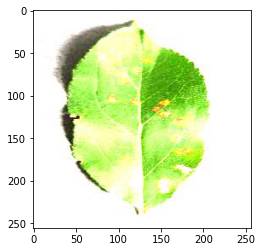

In [27]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [28]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHeal